<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Setup
(No need to change anything)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-uunh_sm9
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-uunh_sm9
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 829084a53836c5b8b388aa37a5ffce73b6371712
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━

In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
# torch.set_grad_enabled(False)

# Load Model and Dataset

## Model

Decide which model to use (eg. gpt2-small vs -medium)

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## Inputs

In [ ]:
names = ["table", "lamp", "fridge", "chair", "hat"]

# nw = [
#     "January", "February", "March", "April", "May", "June",
#     "July", "August", "September", "October", "November", "December"
# ]
nw = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

prompts = ["{} {} {} {} {} {} {} {} {}".format(i, nw[i], i+1, nw[i+1], i+2, nw[i+2], i+3, nw[i+3], i+4) for i in range(0, 8)]

In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU
original_logits, local_cache = model.run_with_cache(tokens) # Run the model and cache all activations

local_tokens = tokens[0]
# Tokenized sentence is stored in token_list and the tokens you are interested in are token1 and token2
token_list = model.to_str_tokens(local_tokens)

# Attention Analysis setup

## Index attn pat fns

In [ ]:
def get_ind(token_list, token1, token2, printInd=False):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        if printInd:
            print(f"The index of '{token1}' is {query_ind}")
            print(f"The index of '{token2}' is {key_ind}")
    return query_ind, key_ind

The index of ' Mar' is 6
The index of ' Feb' is 4


(6, 4)

# Early heads

## Number Detection/Similar Type Heads

In [ ]:
def visualize_attention_patterns(
    layer, head_index,
    highlightLines = True,
    savePlotName = ''
):
    patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy() # Convert tensor to numpy for visualization

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)
    str_tokens[0] = '<PAD>' # Rename the first token string as '<END>'

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        # cmap='viridis',
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',  # Set line color to white
        # cbar_kws={'label': 'Attention Weight'}
        mask=mask
    )

    # Move x-axis ticks to the top
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position('top')

    ax.set_xlabel('Key', fontsize=16, fontweight='bold', labelpad=20)
    ax.set_ylabel('Query', fontsize=16, fontweight='bold', labelpad=20)

    if highlightLines:
        # token_pairs_highL = [(' February', ' January'), (' March', ' February'), (' April', ' March')]
        token_pairs_highL = [(' Feb', ' Jan'), (' Mar', ' Feb'), (' Apr', ' Mar')]

        for qk_toks in token_pairs_highL:
            qInd, kInd = get_ind(token_list, qk_toks[0], qk_toks[1])
            plt.plot([0, kInd+1], [qInd, qInd], color='#7FFF00', linewidth=5)  # top of highL row; pink- FF33D4 ; red- FF3C33 ; FF69B4
            # plt.plot([0, kInd+1], [qInd+1, qInd+1], color='lime', linewidth=3.5)  # bot of highL row ; 3390FF
            # plt.plot([kInd, kInd], [qInd, len(str_tokens)], color='cyan', linewidth=3.5)  # left of highL col
            plt.plot([kInd+1, kInd+1], [qInd, len(str_tokens)], color='blue', linewidth=5)  # right of highL col

            # Change the color of highL row and col ticklabels
            yticklabels = ax.get_yticklabels()
            yticklabels[qInd].set_color('green')
            yticklabels[qInd].set_fontweight('bold')  # Optionally make it bold
            yticklabels[qInd].set_fontsize(14)
            ax.set_yticklabels(yticklabels)
            xticklabels = ax.get_xticklabels()
            xticklabels[kInd].set_color('blue')
            xticklabels[kInd].set_fontweight('bold')  # Optionally make it bold
            xticklabels[kInd].set_fontsize(14)
            ax.set_xticklabels(xticklabels)

    if savePlotName != '':
        plt.savefig(savePlotName + '.pdf', bbox_inches='tight')
        files.download(savePlotName + '.pdf')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

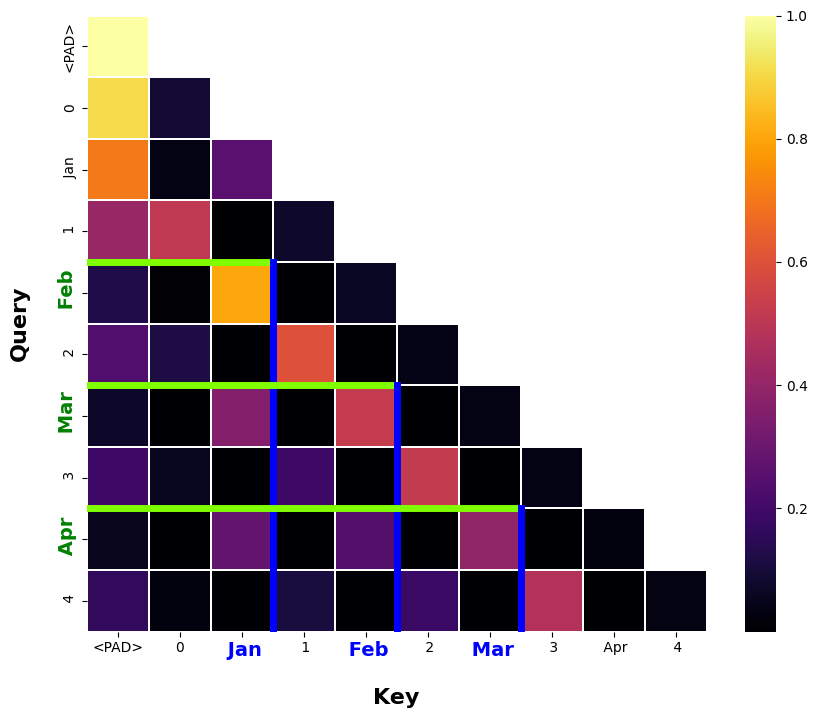

In [ ]:
visualize_attention_patterns(layer = 1, head_index = 5, highlightLines=True, savePlotName='attnpat1_5_among_months')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

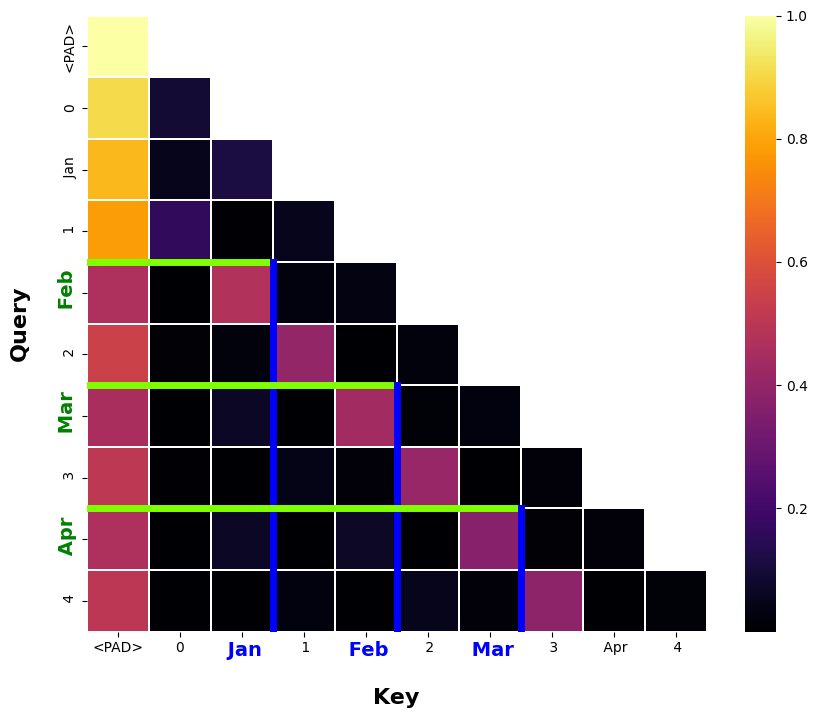

In [ ]:
visualize_attention_patterns(layer = 4, head_index = 4, savePlotName='attnpat4_4_randWords')